<a href="https://colab.research.google.com/github/astrodeepnet/sbi_experiments/blob/affine_sigmoid_bijecctor/notebooks/score_matching/NF_mixture_sigmoid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nomalizing Flow with implicit coupling layers


In [1]:
!pip install --quiet --upgrade pip
# Installs the wheel compatible with CUDA 11 and cuDNN 8.2 or newer.
!pip install --quiet --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_releases.html  # Note: wheels only available on linux.
!pip install --quiet --upgrade dm-haiku optax tensorflow-probability jaxopt
!pip install --quiet git+https://github.com/astrodeepnet/sbi_experiments.git@affine_sigmoid_bijecctor

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 850 kB 5.6 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 149.4 MB 16 kB/s             
     |████████████████████████████████| 287 kB 5.4 MB/s            
     |████████████████████████████████| 126 kB 69.4 MB/s            
     |████████████████████████████████| 98 kB 9.7 MB/s             
     |████████████████████████████████| 65 kB 3.7 MB/s             
  Preparing metadata (setup.py) ... done


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
import numpy as onp
import haiku as hk
import optax
from functools import partial
from tqdm import tqdm
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

Populating the interactive namespace from numpy and matplotlib


In [3]:
d=2
batch_size = 1024

In [4]:
from sbiexpt.distributions import get_two_moons
from sbiexpt.bijectors import MixtureAffineSigmoidBijector 

In [7]:
@jax.jit
def get_batch(seed):
  two_moons = get_two_moons(sigma = 0.01, normalized=True)
  #seed = jax.random.PRNGKey(0)  # Uncomment to fix the samples
  batch = two_moons.sample(batch_size, seed=seed)
  score = jax.vmap(jax.grad(two_moons.log_prob))(batch)
  return batch, score

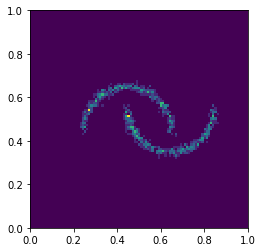

In [8]:
batch, score = get_batch(jax.random.PRNGKey(0))
hist2d(batch[:,0], batch[:,1],100, range=[[0,1],[0,1]]); gca().set_aspect('equal');

In [26]:
class CustomCoupling(hk.Module):
  """This is the coupling layer used in the Flow."""
  def __call__(self, x, output_units, **condition_kwargs):

    # NN to get a b and c
    net = hk.Linear(256, name='l1')(x)
    net = jax.nn.silu(net)
    net = hk.Linear(256, name='l2')(net)
    net = jax.nn.silu(net)
    
    log_a_bound=4
    min_density_lower_bound=1e-4
    n_components = 16
    
    log_a = jax.nn.tanh(hk.Linear(output_units*n_components, name='l3')(net)) * log_a_bound
    b   = hk.Linear(output_units*n_components, name='l4')(net)
    c   = min_density_lower_bound + jax.nn.sigmoid(hk.Linear(output_units*n_components, name='l5')(net)) * (1 - min_density_lower_bound)
    p = jax.nn.softmax(hk.Linear(n_components, name='l6')(net))
    return MixtureAffineSigmoidBijector(jnp.exp(log_a),b,c, p)

class Flow(hk.Module):
    """A normalizing flow using the coupling layers defined
    above."""
    def __call__(self):
      chain = tfb.Chain([
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(name = 'b1')),
            # tfb.Permute([1,0]),
            # tfb.RealNVP(d//2, bijector_fn=CustomCoupling(name = 'b2')),
            # tfb.Permute([1,0]),
        ])
      
      nvp = tfd.TransformedDistribution(
            tfd.Independent(tfd.TruncatedNormal(0.5*jnp.ones(d), 
                                                0.1*jnp.ones(d), 
                                                0.01,0.99),
                            reinterpreted_batch_ndims=1),
            bijector=chain)
        
      return nvp

In [27]:
model_NF = hk.without_apply_rng(hk.transform(lambda x : Flow()().log_prob(x)))
model_inv = hk.without_apply_rng(hk.transform(lambda x : Flow()().bijector.inverse(x)))
model_sample = hk.without_apply_rng(hk.transform(lambda : Flow()().sample(1024, seed=next(rng_seq))))

In [28]:
rng_seq = hk.PRNGSequence(12)
params = model_NF.init(next(rng_seq), jnp.zeros([1,d]))

In [29]:
# This the loss by NLL
# def loss_fn(params, batch, score):
#   log_prob = jax.vmap((lambda x: model_NF.apply(params, x.reshape([1,2])).squeeze()))(batch)
#   return -jnp.mean(log_prob)

# This is the loss for score matching
def loss_fn(params, batch, score):
  log_prob, out = jax.vmap(jax.value_and_grad(lambda x, p: model_NF.apply(p, x.reshape([1,2])).squeeze()), [0, None])(batch, params) # Here we extract the grad of the model
  return  jnp.mean( jnp.sum((out - score)**2, axis=1))/1000 #-jnp.mean(log_prob) 

In [30]:
@jax.jit
def update(params, opt_state, batch, score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, batch, score)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [51]:
learning_rate=0.0001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

In [32]:
losses = []
master_seed = hk.PRNGSequence(0)

In [52]:
for step in tqdm(range(5000)):
    batch, score = get_batch(next(master_seed))
    l, params, opt_state = update(params, opt_state, batch, score)
    losses.append(l)

100%|██████████| 5000/5000 [01:16<00:00, 64.98it/s]


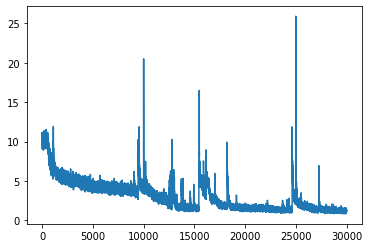

In [53]:
plot(losses[:])

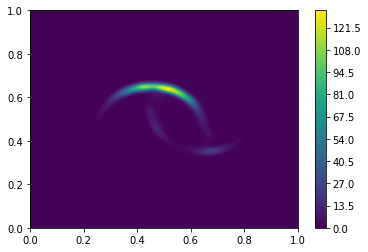

In [56]:
x = jnp.stack(jnp.meshgrid(jnp.linspace(0.,1.,128),
                           jnp.linspace(0.,1.,128)),-1)

im0 = jax.vmap((lambda x: model_NF.apply(params, x.reshape([1,2])).squeeze()))(x.reshape([-1,2])).reshape([128,128])
contourf(x[...,0],x[...,1],jnp.exp(im0), 100); colorbar()

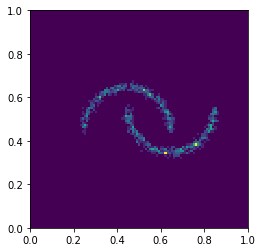

In [57]:
hist2d(batch[:,0], batch[:,1],100, range=[[0,1],[0,1]]);gca().set_aspect('equal');

In [58]:
x = model_inv.apply(params, batch)

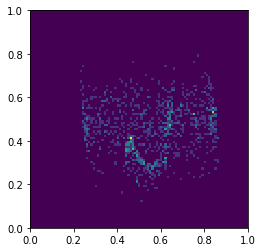

In [59]:
hist2d(x[:,0], x[:,1],100, range=[[0,1],[0,1]]);gca().set_aspect('equal');

In [60]:
x = model_sample.apply(params)

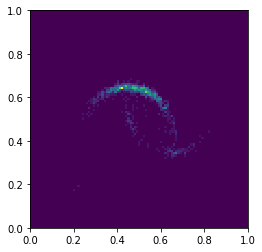

In [61]:
hist2d(x[:,0], x[:,1],100, range=[[0,1],[0,1]]);gca().set_aspect('equal');